In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Analiza pierwszych pięciu wierszy zestawu danych COMPAS, przedstawiającego wrażliwe informacje o osobach osadzonych w więzieniu w hrabstwie Broward na Florydzie.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

compas_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dane/cox-violent-parsed.csv')

compas_df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,0,327,0
1,2.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,334,961,0
2,3.0,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,...,Risk of Violence,2,Low,31/12/2014,30/12/2014,03/01/2015,0,3,457,0
3,4.0,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,...,Risk of Violence,1,Low,27/01/2013,26/01/2013,05/02/2013,0,9,159,1
4,5.0,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,...,Risk of Violence,3,Low,14/04/2013,16/06/2013,16/06/2013,4,0,63,0


## Różne Definicje Sprawiedliwości:

Przeanalizujemy różne definicje sprawiedliwości, takie jak równość demograficzna, równość w błędach modelu oraz podejście proporcjonalne. Każda z tych perspektyw rzutuje światło na aspekty społeczne istotne dla problemu, ukazując jednocześnie kompromisy, jakie musimy podjąć w dążeniu do sprawiedliwości w uczeniu maszynowym.

### 4.1.1 Sformułowanie Problemu i Określenie Sukcesu:

Nasz problem uczenia maszynowego to klasyfikacja binarna, a pytanie brzmi: **"Na podstawie dostępnych informacji o danej osobie, czy możemy precyzyjnie i sprawiedliwie przewidzieć recydywę?"** Wartość "precyzyjnie" odnosi się do standardowych metryk, takich jak dokładność, precyzja i AUC.

### 4.2 Analiza Eksploracyjna Danych:

Celem naszej analizy eksploracyjnej jest bezpośrednie modelowanie etykiety "two_year_recid" na podstawie cech osób. Wśród tych cech znajdują się płeć, wiek, rasa, liczba wcześniejszych przestępstw nieletnich, liczba poprzednich przestępstw, rodzaj przestępstwa itp. Wszystko to po to, aby zrozumieć i przygotować dane do efektywnego trenowania modelu, który będzie zarówno precyzyjny, jak i sprawiedliwy w prognozach dotyczących recydywy.

## Zestaw Cech:

1. **Płeć:** Jakościowa zmienna binarna, przyjmująca wartości "Mężczyzna" lub "Kobieta".
2. **Wiek:** Ilościowa zmienna stosunkowa, mierzona w latach.
3. **Rasa:** Jakościowa zmienna nominalna, reprezentująca przynależność do konkretnej grupy rasowej.
4. **Liczba Ciężkich Przestępstw Nieletnich (juv_fel_count):** Ilościowa zmienna, informująca o liczbie wcześniejszych ciężkich przestępstw nieletnich popełnionych przez daną osobę.
5. **Liczba Wykroczeń Nieletnich (juv_misd_count):** Ilościowa zmienna, przedstawiająca liczbę wcześniejszych przestępstw nieletnich uznawanych za wykroczenia.
6. **Liczba Innych Skazań Nieletnich (juv_other_count):** Ilościowa zmienna, określająca liczbę wcześniejszych skazań nieletnich niebędących ani przestępstwem z użyciem przemocy, ani wykroczeniem.
7. **Liczba Wszystkich Poprzednich Przestępstw (priors_count):** Ilościowa zmienna, wyrażająca sumaryczną liczbę wcześniejszych popełnionych przestępstw przez daną osobę.
8. **Rodzaj Przestępstwa (c_charge_degree):** Jakościowa zmienna binarna, gdzie "F" (felony) oznacza przestępstwo z użyciem przemocy, a "M" (misdemeanor) oznacza wykroczenie.

## Etykieta Odpowiedzi:

- **Czy osoba popełni kolejne przestępstwo w ciągu 2 lat (two_year_recid):** Jakościowa zmienna binarna, informująca, czy dana osoba ponownie popełni przestępstwo w przeciągu 2 lat od momentu zwolnienia.

In [ ]:
# 1. Dobór potrzebnych kolumn
columns_to_keep = ['sex', 'age', 'race', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'c_charge_degree', 'is_recid', 'priors_count']
compas_df.drop(compas_df.columns.difference(columns_to_keep), axis=1, inplace=True)

# 2. Usunięcie pustych wartości
compas_df.dropna()

# 3. Zmiana nazwy kolumny two_year_recid
compas_df.rename(columns={'is_recid': 'two_year_recid'}, inplace=True)
compas_df.drop(compas_df[compas_df['two_year_recid'] == -1].index, inplace=True)

# 4. Czyszczenie kolumny c_charge_degree
compas_df['c_charge_degree'] = compas_df['c_charge_degree'].str.slice(1, 2)
compas_df.drop(compas_df[compas_df['c_charge_degree'].isin(['N', 'C', 'X', 'T'])].index, inplace=True)

compas_df.head()

,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,two_year_recid
0,Male,69,Other,0,0,0,0,F,0
1,Male,69,Other,0,0,0,0,F,0
3,Male,34,African-American,0,0,0,0,F,1
4,Male,24,African-American,0,0,1,4,F,1
5,Male,24,African-American,0,0,1,4,F,1


### Kondensacja Analizy Eksploracyjnej Danych:

1. **Agregacja Przestępstw Nieletnich:**
   - Trzy kategorie zliczające przestępstwa nieletnich zostały połączone w jedną kolumnę, reprezentującą ogólną liczbę popełnionych przestępstw nieletnich przez daną osobę.

2. **Analiza Różnic w Recydywie Według Rasy:**
   - Zauważono istotne różnice w wskaźnikach recydywy między różnymi grupami rasowymi.
   - Obecność dwóch mało licznych kategorii (Azjaci, rdzenni Amerykanie) stanowi wyzwanie związanego z obciążeniem próby.

3. **Przekształcenie Kategorii Rasowych:**
   - Kategorie rasowe (Azjaci, rdzenni Amerykanie) o niewielkiej reprezentacji zostały przekształcone jako "Inne" w celu uniknięcia błędnych interpretacji.

4. **Analiza Stopnia Przestępstw:**
   - Zauważono, że około 65% zarzutów dotyczyło przestępstw z użyciem przemocy (F), a reszta to wykroczenia (M).

5. **Histogramy Cech Ilościowych:**
   - Wartości wieku i priors_count wykazują przekrzywienie w prawo, sugerując korzyści z pewnego stopnia standaryzacji dla ograniczenia wpływu wartości odstających.

In [ ]:
# 1. Agregacja przestępstw nieletnich
compas_df['juv_count'] = compas_df[['juv_fel_count', 'juv_misd_count', 'juv_other_count']].sum(axis=1)
compas_df = compas_df.drop(['juv_fel_count', 'juv_misd_count', 'juv_other_count'], axis=1)
compas_df.head()

,sex,age,race,priors_count,c_charge_degree,two_year_recid,juv_count
0,Male,69,Other,0,F,0,0
1,Male,69,Other,0,F,0,0
3,Male,34,African-American,0,F,1,0
4,Male,24,African-American,4,F,1,1
5,Male,24,African-American,4,F,1,1


In [ ]:
# 2. Analiza różnic w recydywie według rasy
compas_df.groupby('race')['two_year_recid'].describe()

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,9407.0,0.539173,0.498490,0.0,0.0,1.0,1.0,1.0
Asian,64.0,0.296875,0.460493,0.0,0.0,0.0,1.0,1.0
Caucasian,5771.0,0.427309,0.494731,0.0,0.0,0.0,1.0,1.0
Hispanic,1354.0,0.365583,0.481771,0.0,0.0,0.0,1.0,1.0
Native American,51.0,0.490196,0.504878,0.0,0.0,0.0,1.0,1.0
Other,825.0,0.391515,0.488385,0.0,0.0,0.0,1.0,1.0


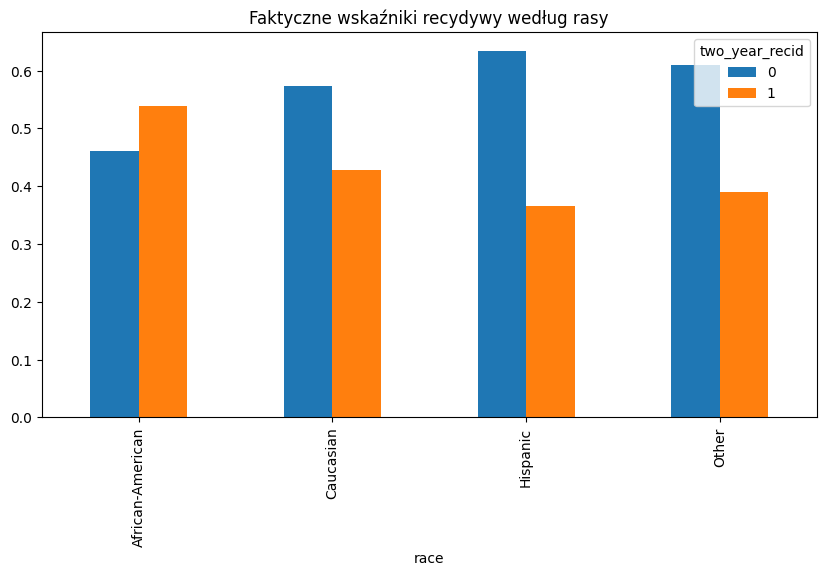

In [ ]:
# 3. Przekształcenie kategorii rasowych
compas_df.loc[compas_df['race'].isin(['Native American', 'Asian']), 'race'] = 'Other'

# Grupowanie według rasy i two_year_recid i generowanie wykresu słupkowego
compas_df.groupby('race')['two_year_recid'].value_counts(normalize=True).unstack().plot(
    kind='bar', figsize=(10, 5), title='Faktyczne wskaźniki recydywy według rasy')

plt.show()

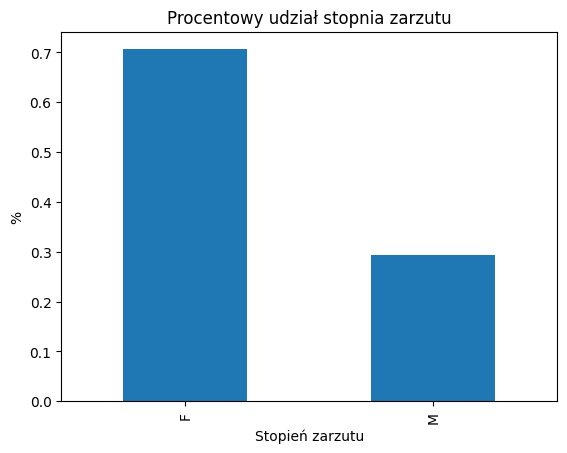

In [ ]:
# 4. Analiza stopnia przestępstw
compas_df['c_charge_degree'].value_counts(normalize=True).plot(
    kind='bar', title='Procentowy udział stopnia zarzutu', ylabel='%', xlabel='Stopień zarzutu')

plt.show()


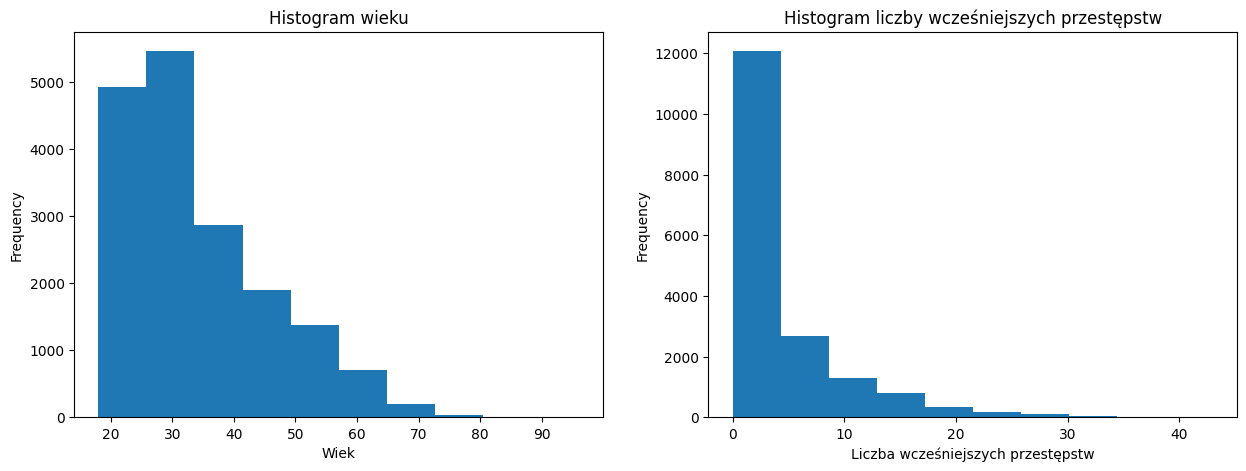

In [ ]:
# 5. Histogramy cech ilościowych

plt.figure(figsize=(15, 5))

# Histogram dla 'age'
plt.subplot(1, 2, 1)
compas_df['age'].plot(kind='hist', title='Histogram wieku')
plt.xlabel('Wiek')

# Histogram dla 'priors_count'
plt.subplot(1, 2, 2)
compas_df['priors_count'].plot(kind='hist', title='Histogram liczby wcześniejszych przestępstw')
plt.xlabel('Liczba wcześniejszych przestępstw')

plt.show()



### 4.3 Pomiar Uprzedzeń i Sprawiedliwości: Kondensacja

#### 4.3.1 Różne Traktowanie a Różne Skutki

- **Różne Traktowanie (Disparate Treatment):** Model opiera predykcje na wrażliwych atrybutach (np. płci, rasy).
  
- **Różne Skutki (Disparate Impact):** Skutki predykcji nierówno wpływają na osoby o różnych cechach wrażliwych, tworząc niesprawiedliwość.

#### 4.3.2 Definicje Sprawiedliwości

**BRAK WIEDZY (UNAWARENESS):**
- Model ignoruje wrażliwe atrybuty w danych treningowych.
- Łatwe do zrozumienia, ale może doprowadzić do odtwarzania wrażliwych cech przez model.

**RÓWNOWAGA STATYSTYCZNA:**
- Przewidywania są niezależne od cech wrażliwych.
- Możliwe wykorzystanie reguły czterech piątych.
- Proste wytłumaczenie, ale ignoruje zależności między etykietą a cechą wrażliwą.

**RÓWNE SZANSE:**
- Przewidywania są niezależne od cech wrażliwych, warunkowo na rzeczywistą odpowiedź.
- Karze lenistwo modelu i skupia się na doskonaleniu dokładności we wszystkich grupach.
- Wrażliwe na różnice w bazowych wskaźnikach odpowiedzi.

W ramach procesu budowy naszego bazowego modelu uczenia maszynowego, skupiliśmy się na kilku kluczowych etapach, mających na celu uzyskanie wyważonego i sprawiedliwego modelu.

#### 4.4.1 Konstrukcja Cech

Podczas analizy eksploracyjnej danych (EDA) zidentyfikowaliśmy trzy cechy związane z liczbą przestępstw popełnionych przez osoby w okresie nieletniości. Te cechy stanowiły podstawę naszego modelu i wymagały dodatkowej inżynierii, aby zagwarantować, że model skutecznie interpretuje dane.

#### 4.4.2 Budowanie Procedury Przetwarzania

Rozpoczęliśmy proces budowy naszej procedury przetwarzania, zaczynając od podziału danych na zbiory treningowe i testowe. Wybraliśmy model lasu losowego jako klasyfikator, ze względu na jego zdolność do obliczania ważności cech. To umożliwiło nam skonfigurowanie jednolitej procedury przetwarzania, która obejmowała zarówno dane kategorialne, jak i numeryczne.

#### 4.4.3 Pomiar Uprzedzeń w Modelu Bazowym

Kolejnym krokiem było ocenienie uprzedzeń w naszym modelu. Wykorzystaliśmy moduł Dalex, który dostarczył nam informacje o ważności cech, a także metryki sprawiedliwości, takie jak czułość (TPR), precyzja (PPV) i równość na poziomie grupy (STP).

#### 4.4.4 Kumulacyjna Utrata Równości

Aby bardziej kompleksowo zrozumieć poziom uprzedzeń w modelu, stworzyliśmy kumulacyjny wykres utraty równości. Ten wykres przedstawiał ogólną tendencję modelu do generowania uprzedzeń, a wartość utraty równości dla modelu bazowego wyniosła około 3,5.

Wnioski z tej oceny skłoniły nas do podjęcia działań w zakresie inżynierii cech w celu łagodzenia uprzedzeń w danych. Naszym celem jest teraz zoptymalizowanie modelu pod kątem zarówno wydajności, jak i sprawiedliwości.

In [ ]:
# Podział danych na zbiory treningowe i testowe
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test, race_train, race_test = train_test_split(
    compas_df.drop('two_year_recid', axis=1),
    compas_df['two_year_recid'],
    compas_df['race'],
    stratify=compas_df['two_year_recid'],
    test_size=0.3,
    random_state=0)

classifier = RandomForestClassifier(
    max_depth=10, n_estimators=20, random_state=0)

In [ ]:
print(X_train.head())

          sex  age              race  priors_count c_charge_degree  juv_count
12145    Male   21  African-American             3               F          0
7578   Female   25  African-American             0               F          0
16975    Male   32  African-American             0               F          0
5744     Male   52          Hispanic             2               F          0
11683    Male   30         Caucasian             0               F          0


In [ ]:
# Tworzenie procedury przetwarzania danych jakościowych
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import OneHotEncoder, StandardScaler

categorical_features = ['race', 'sex', 'c_charge_degree']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='if_binary'))])

In [ ]:
# Tworzenie procedury przetwarzania danych ilościowych
numerical_features = ['age', 'priors_count']
numerical_transformer = Pipeline(steps=[
 ('scale', StandardScaler())])

In [ ]:
# Łączenie procedur przetwarzania danych do preprocessingu cech
preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features),
    ('num', numerical_transformer, numerical_features)])

clf_tree = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)])

In [ ]:
# Uruchamianie modelu nieświadomego uprzedzeń na zestawie testowym
clf_tree.fit(X_train, y_train)
unaware_y_preds = clf_tree.predict(X_test)
unaware_y_preds

# Unaware_y_preds to tablica 0 i 1, gdzie 0 oznacza brak recydywy, a 1 oznacza przewidywanie recydywy przez model. Teraz, gdy mamy te prognozy dla zestawu testowego, czas sprawdzić, jak sprawiedliwy jest nasz model ML.

array([0, 1, 1, ..., 1, 1, 0])

In [ ]:
preprocessor.fit_transform(X_train).shape

(12230, 10)

In [ ]:
pip install dalex


In [20]:
# # Wykorzystanie Dalex do wyjaśnienia modelu
import dalex as dx
exp_tree = dx.Explainer(
 clf_tree, X_test, y_test,
 label='Random Forest Bias Unaware', verbose=True)
exp_tree.model_performance()


Preparation of a new explainer is initiated

  -> data              : 5242 rows 6 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 5242 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : Random Forest Bias Unaware
  -> predict function  : <function yhat_proba_default at 0x7b0964d16290> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0171, mean = 0.484, max = 0.997
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.949, mean = -0.00313, max = 0.961
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
Random Forest Bias Unaware,0.673016,0.680032,0.676506,0.690576,0.75214


Nasze metryki nie są rewelacyjne, ale zależy nam zarówno na wydajności, jak i na sprawiedliwości. Sprawdźmy, na ile model naszego klasyfikatora polegał na rasie jako czynniku przewidywania recydywy. To pytanie jest związane z różnicami w traktowaniu. Dalex dostarcza wygodny wykres, który pomaga wizualizować, z jakich cech nasz model czerpał najwięcej informacji.

In [21]:
exp_tree.model_parts().plot()

Zanim rozpoczniemy nasz taniec bez uprzedzeń, powinniśmy przyjrzeć się kilku innym metrykom. Dalex posiada również obiekt model_fairness, który pozwala nam obliczyć kilka metryk dla każdej z naszych kategorii rasowych, jak pokazano w poniższym zestawieniu z wynikami. Pakiet ten dostarcza nam domyślnie 10 metryk; przeanalizujmy, jak obliczyć każdą z nich w odniesieniu do prawdziwie pozytywnych (TP), fałszywie pozytywnych (FP), fałszywie negatywnych (FN), rzeczywistych pozytywnych (AP), rzeczywistych negatywnych (AN), przewidywanych pozytywnych (PP) i przewidywanych negatywnych (PN). Pamiętajmy, że każdą z tych metryk możemy obliczyć w podziale na grupy rasowe:

1. Czułość (TPR) dla danej rasy r = TP / AP (inaczej: czułość)
2. Specyficzność (TNR) dla danej rasy r = TN / AN (inaczej: specyficzność)
3. Precyzja (PPV) dla danej rasy r = TP / (PP) (inaczej: precyzja)
4. Wartość predykcyjna negatywna (NPV) dla danej rasy r = TN / (PN)
5. FNR(r) = FN / AP lub 1 - TPR
6. FPR(r) = FP / AN lub 1 - TNR
7. FDR(r) = FP / (PP) lub 1 - PPV
8. FOR(r) = FN / (PN) lub 1 - NPV
9. ACC(r) = TP + TN / (TP + TN + FP + FN) (ogólna dokładność według rasy)
10. STP(r) = TP + FP / (TP + FP + FP + FN) (inaczej: P[recydywa przewidziana | Rasa = r])

Same te liczby nie będą zbyt pomocne, dlatego przeprowadźmy test sprawiedliwości, porównując nasze wartości do uprzywilejowanej grupy ludzi: Kaukaskiej. Dlaczego wybieramy Kaukazjan jako naszą uprzywilejowaną grupę? Cóż, między innymi, jeśli spojrzymy na to, jak często nasz bazowy model przewidywał recydywizm między naszymi grupami, zauważymy, że model znacznie niedoszacowuje recydywizmu w przypadku Kaukazjan w porównaniu do rzeczywistych wskaźników w naszym zestawie testowym.

In [26]:
# Eksportowanie sprawiedliwości modelu
mf_tree = exp_tree.model_fairness(
 protected=race_test, privileged = "Caucasian")


# TPR(r) = TP / AP                           ( aka sensitivity )
# TNR(r) = TN / AN                           ( aka specificity )
# PPV(r) = TP / (PP)                         ( aka precision )
# NPV(r) = TN / (PN)
# FNR(r) = FN / AP  OR 1 - TPR
# FPR(r) = FP / AN  OR 1 - TNR
# FDR(r) = FP / (PP) OR 1 - PPV
# FOR(r) = FN / (PN) OR 1 - NPV
# ACC(r) = TP + TN  / (TP + TN + FP + FN)    ( Overall accuracy by Race)
# STP(r) = TP + FP / (TP + FP + FP + FN)     ( aka P[recidivism predicted | Race=r] )


mf_tree.metric_scores

,TPR,TNR,PPV,NPV,FNR,FPR,FDR,FOR,ACC,STP
African-American,0.781,0.572,0.679,0.692,0.219,0.428,0.321,0.308,0.684,0.618
Caucasian,0.484,0.833,0.686,0.682,0.516,0.167,0.314,0.318,0.683,0.303
Hispanic,0.549,0.845,0.683,0.755,0.451,0.155,0.317,0.245,0.733,0.304
Other,0.642,0.799,0.660,0.786,0.358,0.201,0.340,0.214,0.740,0.368


In [23]:
# Obliczanie średnich wartości etykiety docelowej w grupie testowej
mean_recidivism_by_race = y_test.groupby(race_test).mean()

# Tworzenie Series z przewidywanymi wartościami dla etykiet docelowych i grupowanie po rasie
mean_unaware_y_preds_by_race = pd.Series(unaware_y_preds, index=y_test.index).groupby(race_test).mean()

print("Aktualne średnie wskaźniki recydywy według grupy rasowej:")
print(mean_recidivism_by_race)

print("\nŚrednie przewidywane wskaźniki recydywy według grupy rasowej (model bez uwzględnienia uprzedzeń):")
print(mean_unaware_y_preds_by_race)

Aktualne średnie wskaźniki recydywy według grupy rasowej:
race
African-American    0.537451
Caucasian           0.429561
Hispanic            0.377778
Other               0.378472
Name: two_year_recid, dtype: float64

Średnie przewidywane wskaźniki recydywy według grupy rasowej (model bez uwzględnienia uprzedzeń):
race
African-American    0.617678
Caucasian           0.303118
Hispanic            0.303704
Other               0.368056
dtype: float64


Dla celów analizy skoncentrujemy się głównie na TPR, ACC, PPV, FPR i STP:

- TPR: Jak dobrze model uchwytuje faktyczne przypadki recydywy?
- ACC: Ogólna dokładność modelu.
- PPV: Precyzja – ile razy model poprawnie przewiduje recydywę spośród pozytywnych przewidywań.
- FPR: Tempo przewidywania recydywy, gdy faktycznie jej nie ma.
- STP: Równość statystyczna na grupę – oczekujemy, aby była zbliżona dla każdej grupy etnicznej, co oznacza, że model powinien wiarygodnie przewidywać recydywę na podstawie niemonitorowanych informacji demograficznych.

Wyniki są przedstawione w tabeli poniżej. Skupiamy się głównie na wartościach między (0,8 a 1,25). Wartości wytłuszczone wskazują na obecność potencjalnych uprzedzeń.

In [27]:
# Assuming you have already created and fitted exp_tree (the Explainer)
privileged_group = 'Caucasian'
mf_tree = exp_tree.model_fairness(protected=race_test, privileged=privileged_group)
mf_tree.fairness_check()


Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Caucasian'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                       TPR       ACC       PPV       FPR       STP
African-American  1.613636  1.001464  0.989796  2.562874  2.039604
Hispanic          1.134298  1.073206  0.995627  0.928144  1.003300
Other             1.326446  1.083455  0.962099  1.203593  1.214521


Każda wartość w tabeli to wynik z metric_scores podzielony przez wartość dla grupy Kaukaskiej. Na przykład wartość TPR dla Afroamerykanów wynosi 1,352531, co oznacza TPR(Afroamerykanin) / TPR(Kaukaska), czyli 0,775 / 0,573. Następnie te proporcje są sprawdzane w stosunku do zakresu (0,8, 1,25), a wartości spoza tego zakresu uznajemy za niesprawiedliwe. Wartość idealna to 1, co oznacza, że metryka dla danej grupy jest równa wartości dla grupy Kaukaskiej.

In [25]:
mf_tree.plot() # Same numbers from the fairness_check in a plot


Możemy obliczyć utratę równości dla STP w naszym modelu bez uwzględniania uprzedzeń jako 0,921. Dalex dostarcza prostszą metodę obliczenia utraty równości dla wszystkich pięciu metryk i zestawienia ich w wykresie. Figura 4.15 będzie używana do porównań między modelami, a pięć stosów reprezentuje wartości każdej z pięciu metryk uprzedzeń. Chcemy, aby ogólna długość stosu zmniejszała się, co świadczy o mniejszej skłonności do uprzedzeń. Ten wykres będzie zestawiany z klasycznymi metrykami uczenia maszynowego, takimi jak dokładność, precyzja i czułość.

In [28]:
mf_tree.plot(type = 'stacked')

### 4.5 Niwelowanie Uprzedzeń

W kontekście niwelowania uprzedzeń i promowania sprawiedliwości w modelach uczenia maszynowego rozważamy trzy główne strategie:

#### 4.5.1 Przetwarzanie Wstępne

Przetwarzanie wstępne to techniki stosowane do danych treningowych przed samym procesem modelowania. W tym rozdziale skupimy się na dwóch konkretnych metodach:

1. **Usuwanie Uprzedzeń przez Edycję Cech:** Edytowanie wartości cech w celu poprawy uczciwości grupowej.
2. **Uczenie Uczciwych Reprezentacji:** Tworzenie nowego zestawu cech poprzez zacieranie pierwotnych informacji dotyczących chronionych atrybutów.

Te techniki mają na celu zminimalizowanie ogólnego uprzedzenia modelu, jednocześnie dążąc do poprawy jego wydajności.

#### 4.5.2 Przetwarzanie w Trakcie

Przetwarzanie w trakcie odnosi się do technik stosowanych podczas fazy treningowej modelu. Przykłady obejmują:
   
1. **Meta Sprawiedliwy Klasyfikator:** Wykorzystuje uczciwość jako kryterium optymalizacyjne dla klasyfikatora podczas treningu.
   
2. **Usuwacz Uprzedzeń:** Wprowadza regularyzację związaną z uczciwością w procesie treningowym, dążąc do osiągnięcia uczciwego modelu.

#### 4.5.3 Przetwarzanie Końcowe

Techniki przetwarzania końcowego mają zastosowanie po zakończeniu treningu modelu. Są szczególnie użyteczne, gdy model traktujemy jako czarną skrzynkę. Przykłady obejmują:

1. **Zrównoważone Szanse:** Modyfikacja przewidywanych etykiet w celu uczynienia prognoz bardziej uczciwymi.
   
2. **Skalibrowane Równe Szanse:** Modyfikowanie wyników klasyfikatora po treningu w celu uzyskania bardziej sprawiedliwych rezultatów.

### 4.6 Budowanie Modelu Świadomego Uprzedzeń

Rozpoczynamy proces konstruowania bardziej świadomego modelu, wykorzystując dwie techniki inżynierii cech, aby zminimalizować uprzedzenia, nie rezygnując zbyt wiele z wydajności.

#### 4.6.1 Konstrukcja Cech: Użycie Transformatora Yeo-Johnson

Rozważamy transformację cech za pomocą transformatora Yeo-Johnson, podobnie jak wcześniej użyliśmy Box-Cox do przekształcenia cech na rozkład normalny. Analizujemy wpływ cechy "priors_count" na uprzedzenia, zwłaszcza w kontekście ras. Wykrywamy, że liczba wcześniejszych przestępstw różni się istotnie między grupami rasowymi, co może prowadzić do uprzedzeń. Wprowadzamy niestandardowy transformator, który stosuje transformację Yeo-Johnson dla każdej grupy wartości związanej z daną rasą, eliminując nierówności oddziaływania.

#### 4.6.2 Ekstrakcja Cech: Implementacja Nauki Uczciwej Reprezentacji za pomocą AIF360

Korzystamy z narzędzia AIF360 do implementacji nauki uczciwej reprezentacji (LFR). LFR odwzorowuje dane na nowe cechy, tworząc bardziej uczciwą reprezentację w odniesieniu do zmiennych wrażliwych, takich jak rasa. Implementujemy niestandardowy transformator, korzystając z LFR w AIF360, aby osiągnąć bardziej uczciwą reprezentację danych.

#### 4.6.3 Wykorzystanie Nowego Transformatora

Modyfikujemy potok przetwarzania danych, integrując nasz nowy transformator za pomocą obiektu `FeatureUnion`. Mimo że konieczne było dostosowanie obiektów DataFrame do specyficznego formatu AIF360, nasz ostateczny model z usuwaniem wpływu i zastosowaniem LFR wydaje się mieć potencjalnie lepszą wydajność niż oryginalny model bazowy.

Kończymy analizę, sprawdzając, czy skumulowana utrata równości zmierza w pożądanym kierunku, co potwierdza skuteczność wprowadzonych transformacji.

In [36]:
def show_proportions(sensitive_features, y_pred, y=None, description=None):
    print(f'\n{description}\n')
    indices = {}
    positive_indices = {}
    negative_indices = {}
    groups = np.unique(sensitive_features.values)
    n_groups = len(groups)
    max_group_length = max([len(group) for group in groups])
    for index, group in enumerate(groups):
        indices[group] = sensitive_features.index[sensitive_features == group]
        group_recidivism_pct = round(sum(y_pred[indices[group]]) / len(indices[group]), 5)
        buffer = " " * (max_group_length - len(group))
        print(f'P(recidivism | {group})                {buffer}= {group_recidivism_pct}')

        if y is not None:
            positive_indices[group] = sensitive_features.index[
                (sensitive_features == group) & (y == True)
            ]
            negative_indices[group] = sensitive_features.index[
                (sensitive_features == group) & (y == False)
            ]
            prob_1 = round(sum(y_pred[positive_indices[group]]) / len(positive_indices[group]), 5)
            prob_0 = round(sum(y_pred[negative_indices[group]]) / len(negative_indices[group]), 5)

            print(f'P(recidivism | {group}, recidivism)    {buffer}= {prob_1}')
            print(f'P(recidivism | {group}, no recidivism) {buffer}= {prob_0}')

In [37]:
show_proportions(
    race_test,
    y_test,
    description="original test data:"
)
show_proportions(
    race_test,
    pd.Series(unaware_y_preds, index=y_test.index),
    y=y_test,
    description="fairness-unaware prediction on test data:"
)
plt.show()


original test data:

P(recidivism | African-American)                = 0.53745
P(recidivism | Caucasian)                       = 0.42956
P(recidivism | Hispanic)                        = 0.37778
P(recidivism | Other)                           = 0.37847

fairness-unaware prediction on test data:

P(recidivism | African-American)                = 0.61768
P(recidivism | African-American, recidivism)    = 0.78071
P(recidivism | African-American, no recidivism) = 0.42824
P(recidivism | Caucasian)                       = 0.30312
P(recidivism | Caucasian, recidivism)           = 0.48387
P(recidivism | Caucasian, no recidivism)        = 0.167
P(recidivism | Hispanic)                        = 0.3037
P(recidivism | Hispanic, recidivism)            = 0.54902
P(recidivism | Hispanic, no recidivism)         = 0.15476
P(recidivism | Other)                           = 0.36806
P(recidivism | Other, recidivism)               = 0.6422
P(recidivism | Other, no recidivism)            = 0.20112


In [38]:
# Feature construction: Wykorzystanie transformatora Yeo-Johnson do eliminacji nierówności wpływu.
compas_df.corrwith(compas_df['race'] == 'African-American').sort_values()

<ipython-input-38-6270799cffbc>:2: FutureWarning:

The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



age              -0.174068
two_year_recid    0.126245
juv_count         0.126850
priors_count      0.204198
dtype: float64

Wiek i liczba wcześniejszych przestępstw (priors_count) są silnie skorelowane z etykietą oznaczającą bycie Afroamerykaninem. Analizując wiek, zauważamy, że dla różnych kategorii rasowych rozkład ten jest podobny, co sugeruje, że wiek nie jest kluczowym czynnikiem wpływającym na uprzedzenia modelu.

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,9407.0,32.068141,10.665717,18.0,24.0,29.0,37.00,77.0
Caucasian,5771.0,36.594178,12.361577,18.0,26.0,34.0,46.00,83.0
Hispanic,1354.0,34.797637,11.884159,18.0,25.0,32.0,42.75,96.0
Other,940.0,35.088298,11.798164,19.0,25.0,33.0,42.00,76.0


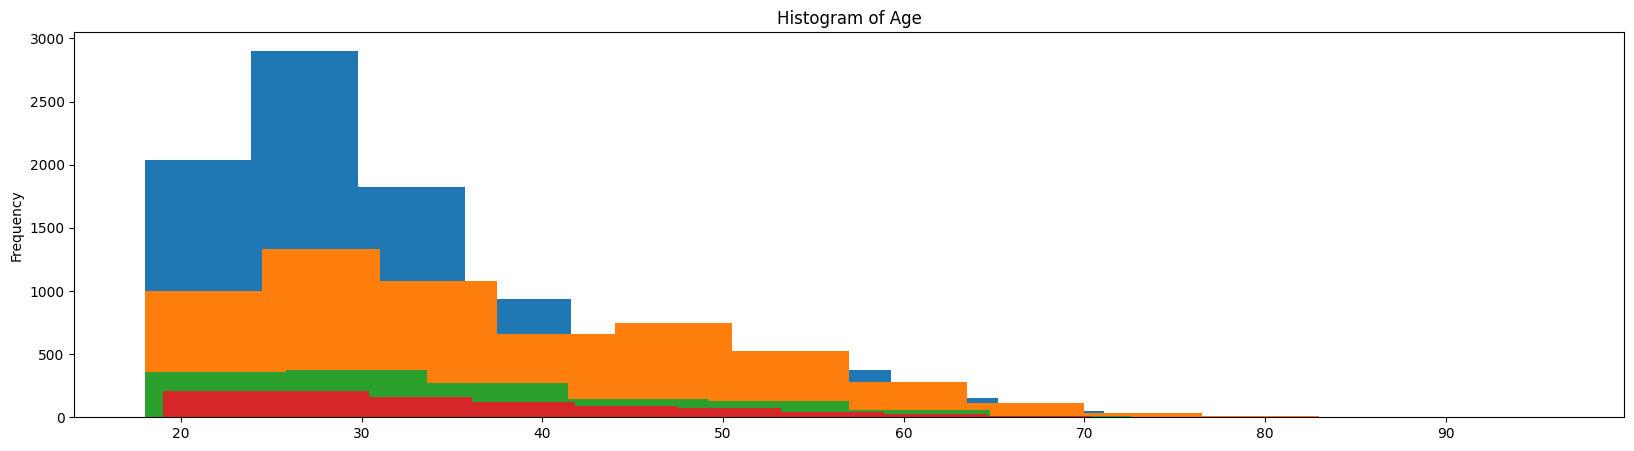

In [31]:
compas_df.groupby('race')['age'].plot(
 figsize=(20,5),
 kind='hist', xlabel='Age', title='Histogram of Age')
compas_df.groupby('race')['age'].describe()

Na pierwszy rzut oka może się wydawać, że wzorce dotyczące przeszłości przestępczej dla wszystkich ras są podobne. Rozkłady liczby wcześniejszych przestępstw (priors count) wykazują podobne przechylenie w prawo między grupami rasowymi. Jednak z powodów niezależnych od wielu osób, mediany i średnie liczby wcześniejszych przestępstw dla Afroamerykanów są niemal dwa razy większe niż dla innych grup.

Warto zauważyć dwie rzeczy:
- Liczba wcześniejszych przestępstw Afroamerykanów jest znacznie przekrzywiona w prawo, co potwierdza fakt, że średnia jest ponad dwukrotnie większa niż mediana.
- Liczba wcześniejszych przestępstw Afroamerykanów jest niemal dwukrotnie większa niż łączna liczba pozostałych grup rasowych, co wynika z długiej historii problemów związanych z systemem sprawiedliwości karnym.

Fakty, że liczba wcześniejszych przestępstw jest silnie skorelowana z rasą, a także że jest różnie przekrzywiona dla różnych kategorii rasowych, stanowią ogromne problemy, głównie dlatego, że model uczenia maszynowego może prawdopodobnie wyłapać te zależności i ulegać uprzedzeniom wobec pewnych ras, po prostu patrząc na kolumnę priors_count.

Aby temu zaradzić, stworzymy niestandardowy transformator, który zmodyfikuje kolumnę, stosując transformację Yeo-Johnson – do każdej podgrupy wartości związanej z daną kategorią rasową. To pomoże usunąć nierównowagę wynikającą z tej kolumny dla naszej równości grupowej.

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,9407.0,5.110343,5.967873,0.0,1.0,3.0,7.0,43.0
Caucasian,5771.0,3.097037,4.330330,0.0,0.0,2.0,4.0,36.0
Hispanic,1354.0,2.452733,3.641296,0.0,0.0,1.0,3.0,26.0
Other,940.0,2.477660,4.431052,0.0,0.0,1.0,3.0,31.0


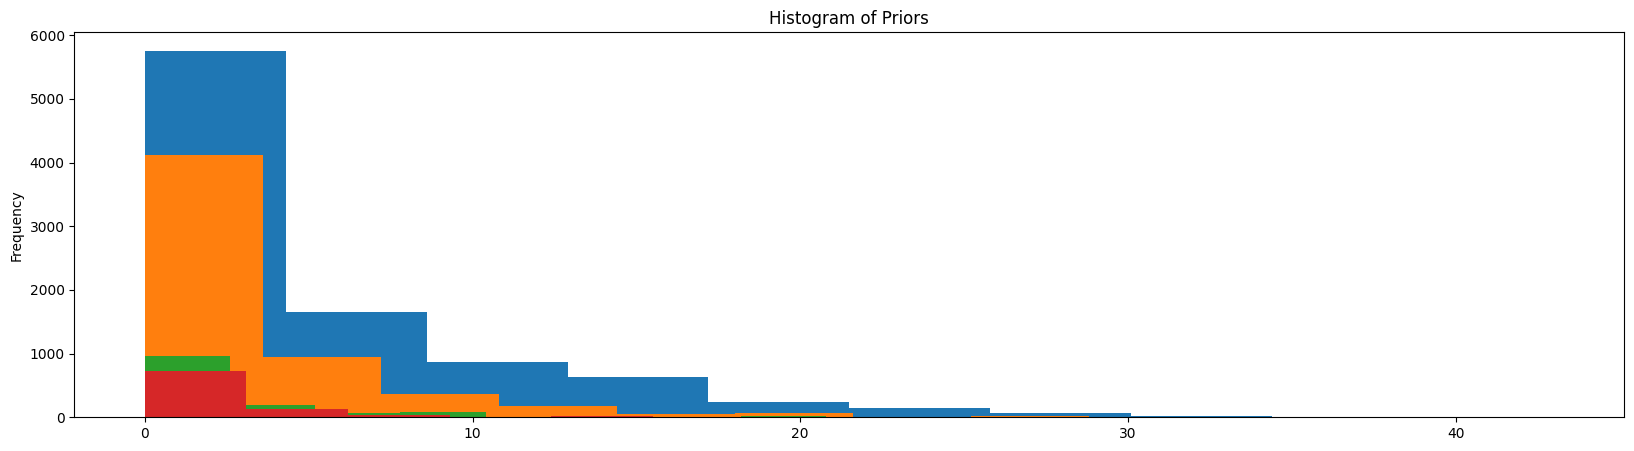

In [32]:
compas_df.groupby('race')['priors_count'].plot(
 figsize=(20,5),
 kind='hist', xlabel='Count of Priors',
title='Histogram of Priors'
)

compas_df.groupby('race')['priors_count'].describe()

transformacja Yeo-Johnson

Dla każdej etykiety grupy:
1. Pobierz podzbiór wartości priors_count dla tej grupy.
2. Zastosuj transformację Yeo-Johnson do podzbioru.
3. Modyfikuj kolumnę w miejscu dla danej etykiety grupy nowymi wartościami.

In [33]:
# Zmniejszenie różnicującego traktowania poprzez Yeo-Johnson
from sklearn.preprocessing import PowerTransformer
from sklearn.base import BaseEstimator, TransformerMixin

class NormalizeColumnByLabel(BaseEstimator, TransformerMixin):
    def __init__(self, col, label):
        self.col = col
        self.label = label
        self.transformers = {}

    def fit(self, X, y=None):
        # Fit PowerTransformer for each unique group in the specified label
        for group in X[self.label].unique():
            self.transformers[group] = PowerTransformer(method='yeo-johnson', standardize=True)
            self.transformers[group].fit(
                X.loc[X[self.label] == group][self.col].values.reshape(-1, 1)
            )
        return self

    def transform(self, X, y=None):
        # Copy the input DataFrame
        C = X.copy()

        # Transform the specified column based on the fitted transformers
        for group in X[self.label].unique():
            C.loc[
                X[self.label] == group, self.col
            ] = self.transformers[group].transform(
                X.loc[X[self.label] == group][self.col].values.reshape(-1, 1)
            )
        return C


Zastosujmy nasz nowy transformator do danych treningowych, aby zobaczyć zmodyfikowane liczniki poprzednich przestępstw, tak aby dla każdej etykiety grupy średnia liczba poprzednich przestępstw wynosiła 0, a odchylenie standardowe 1.

Po zastosowaniu transformacji Yeo-Johnson na podzbiorze liczby poprzednich przestępstw dla każdej grupy, rozkłady zaczynają wyglądać znacznie mniej asymetrycznie i różnić się od siebie. To utrudni modelowi uczenia maszynowego odtworzenie informacji o rasie na podstawie tej cechy.

,count,mean,std,min,25%,50%,75%,max
race,,,,,,,,
African-American,6590.0,-1.277683e-16,1.000076,-1.456868,-0.689000,0.046074,0.866301,2.355193
Caucasian,4039.0,-1.451344e-16,1.000124,-1.284273,-1.284273,0.213889,0.768288,2.315297
Hispanic,949.0,-3.884026e-17,1.000527,-1.201744,-1.201744,-0.054025,0.787472,2.116438
Other,652.0,3.269368e-17,1.000768,-1.044561,-1.044561,0.141635,0.926873,2.018578


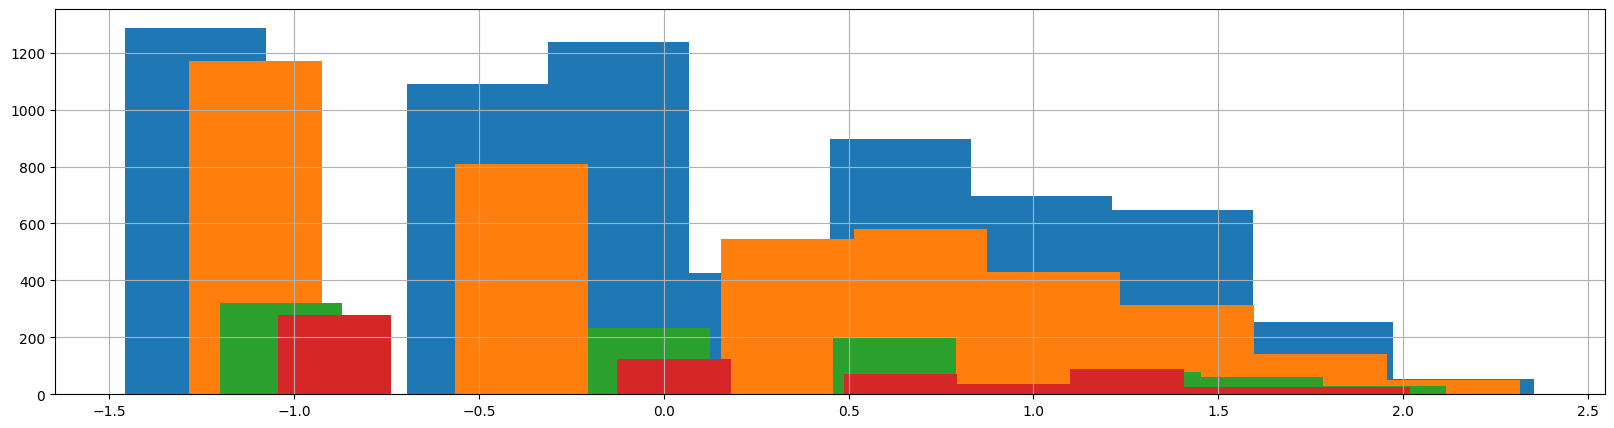

In [39]:
n = NormalizeColumnByLabel(col='priors_count', label='race')
X_train_normalized = n.fit_transform(X_train, y_train)
X_train_normalized.groupby('race')['priors_count'].hist(figsize=(20,5))
X_train_normalized.groupby('race')['priors_count'].describe()

In [40]:
# Tworzenie potoku z transformacją NormalizeColumnByLabel
clf_tree_aware = Pipeline(steps=[
    ('normalize_priors', NormalizeColumnByLabel(col='priors_count', label='race')),
    ('preprocessor', preprocessor),
    ('classifier', classifier)])

# Dopasowywanie modelu świadomego na danych treningowych
clf_tree_aware.fit(X_train, y_train)

# Wykonywanie predykcji za pomocą modelu świadomego
aware_y_preds = clf_tree_aware.predict(X_test)

# Tworzenie eksplainera dla modelu świadomego
exp_tree_aware = dx.Explainer(clf_tree_aware, X_test, y_test, label='Random Forest DIR', verbose=False)

# Obliczanie metryk sprawiedliwości dla modelu świadomego
mf_tree_aware = exp_tree_aware.model_fairness(protected=race_test, privileged="Caucasian")

# Porównywanie wydajności oryginalnego i świadomego modelu
performance_comparison = pd.concat(
    [exp.model_performance().result for exp in [exp_tree, exp_tree_aware]])

# Rysowanie porównania utraty równości
mf_tree.plot(objects=[mf_tree_aware], type='stacked')

exp_tree_aware.model_performance()

,recall,precision,f1,accuracy,auc
Random Forest DIR,0.677381,0.676307,0.676844,0.68905,0.754677


In [41]:
# Porównywanie wydajności oryginalnego i świadomego modelu
exp_tree_aware = dx.Explainer(clf_tree_aware, X_test, y_test, label='Random Forest DIR', verbose=False)
mf_tree_aware = exp_tree_aware.model_fairness(protected=race_test, privileged = "Caucasian")

# performance is virtually unchanged overall
pd.concat([exp.model_performance().result for exp in [exp_tree, exp_tree_aware]])

,recall,precision,f1,accuracy,auc
Random Forest Bias Unaware,0.673016,0.680032,0.676506,0.690576,0.752140
Random Forest DIR,0.677381,0.676307,0.676844,0.689050,0.754677


In [42]:
# Still using the same features, note that race has become less important.
exp_tree.model_parts().plot(objects=[exp_tree_aware.model_parts()])

In [43]:
mf_tree_aware.fairness_check()

Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Caucasian'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                       TPR       ACC       PPV       FPR       STP
African-American  1.571717  0.995614  0.994126  2.482759  1.980769
Hispanic          1.175758  1.068713  0.975037  1.028736  1.060897
Other             1.335354  1.086257  0.970631  1.189655  1.211538


In [44]:
show_proportions(
    race_test,
    y_test,
    description="original test data:"
)
show_proportions(
    race_test,
    pd.Series(unaware_y_preds, index=y_test.index),
    y=y_test,
    description="fairness-unaware prediction on test data:"
)
show_proportions(
    race_test,
    pd.Series(aware_y_preds, index=y_test.index),
    y=y_test,
    description="fairness-aware prediction on test data:"
)
plt.show()


original test data:

P(recidivism | African-American)                = 0.53745
P(recidivism | Caucasian)                       = 0.42956
P(recidivism | Hispanic)                        = 0.37778
P(recidivism | Other)                           = 0.37847

fairness-unaware prediction on test data:

P(recidivism | African-American)                = 0.61768
P(recidivism | African-American, recidivism)    = 0.78071
P(recidivism | African-American, no recidivism) = 0.42824
P(recidivism | Caucasian)                       = 0.30312
P(recidivism | Caucasian, recidivism)           = 0.48387
P(recidivism | Caucasian, no recidivism)        = 0.167
P(recidivism | Hispanic)                        = 0.3037
P(recidivism | Hispanic, recidivism)            = 0.54902
P(recidivism | Hispanic, no recidivism)         = 0.15476
P(recidivism | Other)                           = 0.36806
P(recidivism | Other, recidivism)               = 0.6422
P(recidivism | Other, no recidivism)            = 0.20112

fairness-

Górny pasek przedstawia sumę naszych metryk związanych z uprzedzeniem dla naszego modelu świadomego uprzedzeń, który zanotował niewielki wzrost wydajności modelu (zauważony w tabeli metryk) we wszystkich metrykach, z wyjątkiem recall, gdzie pozostał niezmieniony. Dolny pasek przedstawia oryginalny, nieświadomy uprzedzeń wykres skumulowanej utraty równości, który wcześniej obserwowaliśmy. Ogólnie rzecz biorąc, nowy model bez uprzedzeń radzi sobie lepiej w niektórych metrykach uczenia maszynowego i wykazuje spadek uprzedzeń na podstawie wykresu słupkowego utraty równości. Jesteśmy na właściwej drodze!

Do tej pory nie podjęliśmy działań mających na celu rozwiązanie problemu nieświadomości naszego modelu wrażliwych cech. Zamiast całkowicie eliminować rasę, użyjemy narzędzia AI Fairness 360 (AIF360), jest to otwarte narzędzie opracowane przez IBM, które pomaga naukowcom danych uzyskać dostęp do technik przetwarzania wstępnego, w trakcie przetwarzania i po przetwarzaniu w celu niwelowania uprzedzeń. Stosujemy naszą pierwszą technikę ekstrakcji cech, zwanej uczeniem się sprawiedliwej reprezentacji (LFR). Ideą LFR jest odwzorowanie naszych danych x na nowy zestaw cech, które reprezentują bardziej sprawiedliwą reprezentację w odniesieniu do zmiennych wrażliwych, w tym płci i rasy.

W naszym przypadku postaramy się odwzorować nasze zmienne kategoryczne (4 / 6 z nich reprezentujących rasę) w nową przestrzeń wektorową, która zachowuje statystyczną parzystość i zachowuje jak najwięcej informacji z naszego oryginalnego x.

AIF360 może być nieco trudne do użycia, ponieważ zmusza do korzystania z własnej wersji DataFrame o nazwie BinaryLabelDataset. Listing 4.15 to niestandardowy transformator scikit-learn, który:

1. Przyjmuje x, DataFrame binarnych wartości, które są tworzone z naszego kategorycznego procesora wstępnego.
2. Konwertuje DataFrame na BinaryLabelDataset.
3. Dopasowuje moduł LFR z pakietu AIF360.
4. Przekształca dowolny nowy zestaw danych, używając teraz dopasowanego LFR do odwzorowania go na naszą nową sprawiedliwą reprezentację.

In [ ]:
compas_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 17472 entries, 0 to 18315
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sex              17472 non-null  object
 1   age              17472 non-null  int64 
 2   race             17472 non-null  object
 3   priors_count     17472 non-null  int64 
 4   c_charge_degree  17424 non-null  object
 5   two_year_recid   17472 non-null  int64 
 6   juv_count        17472 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 1.1+ MB


In [ ]:
pip install aif360

In [ ]:
pip install 'aif360[LawSchoolGPA]'

In [ ]:
pip install 'aif360[Reductions]'

In [54]:
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.datasets import BinaryLabelDataset
from sklearn.base import BaseEstimator, TransformerMixin

class LFRCustom(BaseEstimator, TransformerMixin):
    def __init__(self, col, protected_col, unprivileged_groups, privileged_groups):
        # Inicjalizacja obiektu LFRCustom z podanymi parametrami
        self.col = col
        self.protected_col = protected_col
        self.TR = None
        self.unprivileged_groups = unprivileged_groups
        self.privileged_groups = privileged_groups

    def fit(self, X, y=None):
        # Tworzenie obiektu BinaryLabelDataset na podstawie danych wejściowych
        d = pd.DataFrame(X, columns=self.col)
        d['response'] = list(y) if y is not None else False
        binary_df = BinaryLabelDataset(
            df=d,
            protected_attribute_names=self.protected_col,
            label_names=['response']
        )

        # Dopasowanie algorytmu LFR do danych
        self.TR = LFR(
            unprivileged_groups=self.unprivileged_groups,
            privileged_groups=self.privileged_groups,
            seed=0,
            k=2, Ax=0.5, Ay=0.2, Az=0.2,  # Dostosowanie tych hiperparametrów według potrzeb
            verbose=1
        )
        self.TR.fit(binary_df, maxiter=5000, maxfun=5000)
        return self

    def transform(self, X, y=None):
        # Tworzenie obiektu BinaryLabelDataset na podstawie danych wejściowych
        d = pd.DataFrame(X, columns=self.col)
        d['response'] = list(y) if y is not None else False
        binary_df = BinaryLabelDataset(
            df=d,
            protected_attribute_names=self.protected_col,
            label_names=['response']
        )

        # Transformacja danych za pomocą dopasowanego algorytmu LFR
        transformed_data = self.TR.transform(binary_df).convert_to_dataframe()[0].drop(['response'], axis=1)
        return transformed_data


Aby skorzystać z naszego nowego transformatora, będziemy musieli nieco zmodyfikować nasz potok przetwarzania danych i skorzystać z obiektu FeatureUnion, jak pokazano poniżej.

In [55]:
categorical_preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_features)
])

# Right now the aif360 package can only support one privileged and one unprivileged group
privileged_groups = [{'Caucasian': 1}]
unprivileged_groups = [{'Caucasian': 0}]


lfr = LFRCustom(
    col=['African-American', 'Caucasian', 'Hispanic', 'Other', 'Male', 'M'],
    protected_col=sorted(X_train['race'].unique()) ,
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups
)

categorical_pipeline = Pipeline([
    ('transform', categorical_preprocessor),
    ('LFR', lfr),
])

numerical_features = ["age", "priors_count"]
numerical_transformer = Pipeline(steps=[
    ('scale', StandardScaler())
])

numerical_preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_transformer, numerical_features)
])

preprocessor = FeatureUnion([
    ('numerical_preprocessor', numerical_preprocessor),
    ('categorical_pipeline', categorical_pipeline)
])

In [56]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

print(X_train.head())
print(y_train.head())

(12230, 6)
(12230,)
(5242, 6)
          sex  age              race  priors_count c_charge_degree  juv_count
12145    Male   21  African-American             3               F          0
7578   Female   25  African-American             0               F          0
16975    Male   32  African-American             0               F          0
5744     Male   52          Hispanic             2               F          0
11683    Male   30         Caucasian             0               F          0
12145    1
7578     1
16975    0
5744     0
11683    1
Name: two_year_recid, dtype: int64


In [53]:
print("Training Data Columns:", X_train.columns)
print("Test Data Columns:", X_test.columns)

Training Data Columns: Index(['sex', 'age', 'race', 'priors_count', 'c_charge_degree', 'juv_count'], dtype='object')
Test Data Columns: Index(['sex', 'age', 'race', 'priors_count', 'c_charge_degree', 'juv_count'], dtype='object')


In [ ]:
clf_tree_more_aware = Pipeline(steps=[
    ('normalize_priors', NormalizeColumnByLabel(col='priors_count', label='race')),
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])


clf_tree_more_aware.fit(X_train, y_train)

more_aware_y_preds = clf_tree_more_aware.predict(X_test)


In [ ]:
exp_tree_more_aware = dx.Explainer(
    clf_tree_more_aware, X_test, y_test,
    label='Random Forest DIR + LFR', verbose=False
)

mf_tree_more_aware = exp_tree_more_aware.model_fairness(
    protected=race_test, privileged="Caucasian"
)

pd.concat(
    [exp.model_performance().result for exp in [exp_tree, exp_tree_aware, exp_tree_more_aware]]
)
